### 1. Retrieve and load the Olivetti fces dataset

The first thing we need to do is fetching dataset.<br>
Sklearn provides with datasets feature through which we can load Olivetti faces datasets. <br>
According to sklearn's documentation, each row of this dataset corresponds to a face image of 64 x 64 pixels.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces()

X = pd.DataFrame(dataset.data)
y = pd.DataFrame(dataset.target)

Let's get a sense of this dataset's attributes first.

In [2]:
# overview
X.info()
print()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 4096 entries, 0 to 4095
dtypes: float32(4096)
memory usage: 6.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       400 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


In [3]:
# shape
print('Shape of X: ', X.shape)
print('Shaep of y: ', y.shape)

Shape of X:  (400, 4096)
Shaep of y:  (400, 1)


In [4]:
# range
print(f'Range of X: {np.min(np.min(X))} - {np.max(np.max(X))}')
print(f'Range of y: {np.min(np.min(y))} - {np.max(np.max(y))}')

# number of missing values
print()
print('Missing values in X: ', X.isnull().sum().sum())
print('Missing values in y: ', y.isnull().sum().sum())

Range of X: 0.0 - 1.0
Range of y: 0 - 39

Missing values in X:  0
Missing values in y:  0


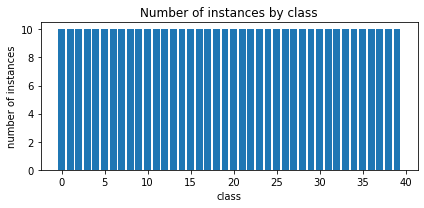

In [5]:
# class balance
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(range(40), [np.where(y == id, 1, 0).sum() for id in range(40)])
ax.set_ylabel('number of instances')
ax.set_xlabel('class')
ax.set_title('Number of instances by class')

fig.tight_layout()
plt.show()

Let's display images of each class (face id)

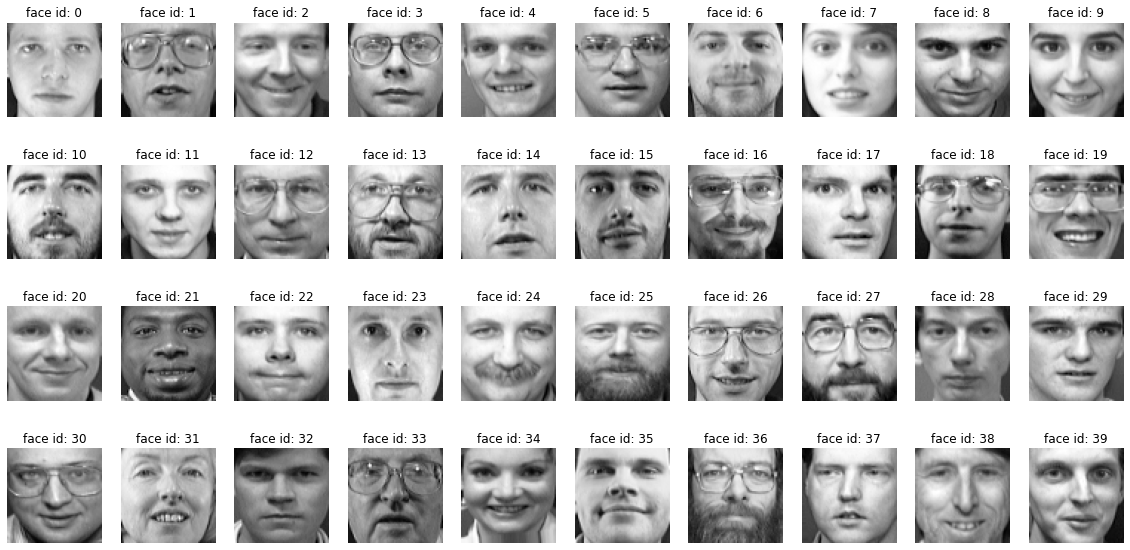

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(20, 10))

def get_unique_ids(classes):
    class_list = list(classes[0])
    indexes = []
    for id in range(40):
        indexes.append(class_list.index(id))
    return indexes

unique_ids = get_unique_ids(y)

for idx, unique_id in enumerate(unique_ids):
    col = idx % 10
    row = idx // 10
    ax[row, col].imshow(X.iloc[unique_id].values.reshape(64,64), cmap='gray')
    ax[row, col].set_title(f'face id: {idx}')
    ax[row, col].axis('off')

From above, we can notice that 
1. dataset consists of 400 instances designating faces
2. there are 64 * 64 (4096) features and each value ranges from 0 to 1
3. targets are integer values well-distributed and ranging from 0 to 39
4. considering that dtype of X and y are float32 and int64 respectively and X and y both have no null value, this dataset has no missing values

### 2. Split dataset using stratified sampling

If we don't consider strata of dataset when we split dataset into training set and test set, our training would be biased, so as the our classification.<br>
We can use stratify property of sklearn train_test_split here. It splits dataset in balanced way based on class.

In [7]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=80, stratify=y, random_state=11)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_full, y_train_full, test_size=40, stratify=y_train_full, random_state=11)

num_of_ids_train = [int((y_train == id).sum()) for id in range(40)]
num_of_ids_validation = [int((y_validation == id).sum()) for id in range(40)]
num_of_ids_test = [int((y_test == id).sum()) for id in range(40)]

Let's take a look at how instances are distributed. Bar chart below shows how classes are distributed in three subsets

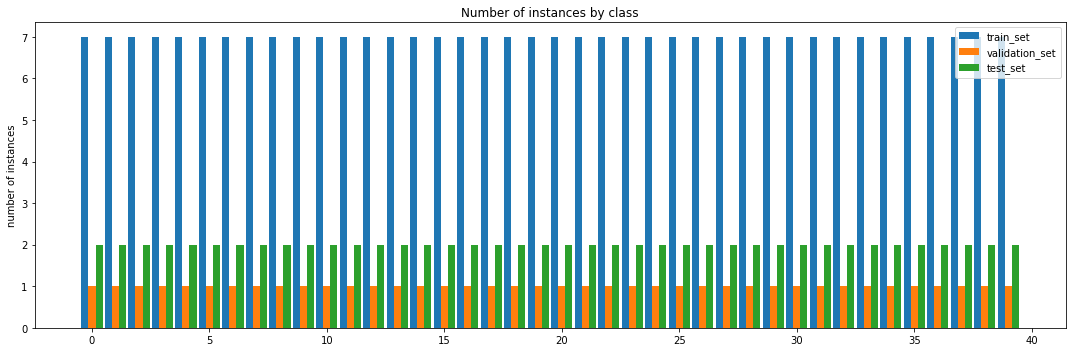

In [8]:
label_loc = np.arange(40)
width = 0.3

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(label_loc - width, num_of_ids_train, width, label='train_set')
rects2 = ax.bar(label_loc, num_of_ids_validation, width, label='validation_set')
rects3 = ax.bar(label_loc + width, num_of_ids_test, width, label='test_set')

ax.set_ylabel('number of instances')
ax.set_title('Number of instances by class')
ax.legend()

fig.tight_layout()
plt.show()

We splitted dataset into train_set, validation_set, and test set in ratio of 7:1:2. 
Rationale of this distribution is as follows.
1. Commonly used and acknowleged ratio between training set and test set is 7:3 or 8:2. Considerting that we don't have enough instances to avoid overfitting, we chose 8:2 to secure training data.
2. Within training set which contains 8 instances for each class, we assigned 1 instance for validation set. The rationale behind this ratio is simiar to the reason above. We lack of the absolute number of instances thinking that we are dealing with data with 4096 features.

### 3. Train a classifier with original dataset

Before training, changing y to one dimensional numpy array is required. <br>
Classifiers of sklearn do not take pandas DataSeries without conversion.

In [9]:
y_train = np.array(y_train[0])
y_validation = np.array(y_validation[0])
y_test = np.array(y_test[0])

Using k-fold cross validation, let's train and evaluate classifiers. Since we have only seven instances for each class, let's set cv to 7. <br>

For selection of classifier, we compared a few models. When it comes to linear SVM(SVC), we exceptionally applied grid search only on its kernel since its behaviours differ significantly based on what kernel it uses.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# linear SVM
param_grid = [{
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}]
grid_svc = GridSearchCV(SVC(), param_grid, cv=5, verbose=0)
grid_svc.fit(X_train, y_train)
clf_svc = grid_svc.best_estimator_
print(f"Best param of svc grid search is {grid_svc.best_params_}")

# decision tree
clf_dt = DecisionTreeClassifier()

# random forest
clf_rf = RandomForestClassifier()

# ada boost
clf_ada = AdaBoostClassifier()

# gaussian naive bayes
clf_nb = GaussianNB()

# kneighbors
clf_kn = KNeighborsClassifier()

Best param of svc grid search is {'kernel': 'linear'}


In [11]:
from sklearn.model_selection import cross_val_score
models = []
models.append(('svc', clf_svc))
models.append(('decision tree', clf_dt))
models.append(('random forest', clf_rf))
models.append(('ada boost', clf_ada))
models.append(('gaussian nb', clf_nb))
models.append(('kneighbors', clf_kn))

for model_name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=7)
    print(f'{model_name}: {scores} - avg: {np.mean(scores):.2f}, std: {np.std(scores):.2f}')

svc: [0.9   0.925 0.95  0.95  0.925 0.975 0.975] - avg: 0.94, std: 0.03
decision tree: [0.575 0.55  0.475 0.525 0.725 0.525 0.575] - avg: 0.56, std: 0.07
random forest: [0.925 0.95  0.9   0.9   0.875 0.925 0.925] - avg: 0.91, std: 0.02
ada boost: [0.225 0.075 0.2   0.175 0.225 0.125 0.275] - avg: 0.19, std: 0.06
gaussian nb: [0.875 0.875 0.9   0.7   0.8   0.775 0.85 ] - avg: 0.82, std: 0.07
kneighbors: [0.75  0.675 0.85  0.625 0.725 0.8   0.775] - avg: 0.74, std: 0.07


SVC with linear kernel looks very promising here. Let's evaluate it again with validation set.

In [12]:
from sklearn.metrics import accuracy_score

clf_svc.fit(X_train, y_train)
y_pred_validation = clf_svc.predict(X_validation)

accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print('Accuracy score: ', accuracy_validation)

Accuracy score:  0.975


In [13]:
y_pred_test = clf_svc.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy score on test set: {accuracy_validation}')

Accuracy score on test set: 0.975


From the result above, we can conclude that
1. svc with linear kernel shows the best capability in classifying face images
2. svc doesn't seem to be overfitting to training dataset since it still shows good accuracy to validation set

### 4. Use K-Means to reduce dimensionality of the set

Since we have too many features, it is good idea to reduce dimensionality. <br>
K-Means is one way of clustering that is commonly used for dimensionality reduction. <br>
From this part, let's apply K-Means to reduce dimensionality and see where it leads to.

What's important in K-means is to set adequate number of clusters. <br>
This number can taken by finding elbow in inertia - k plot or peak in silhoutte score - k plot.

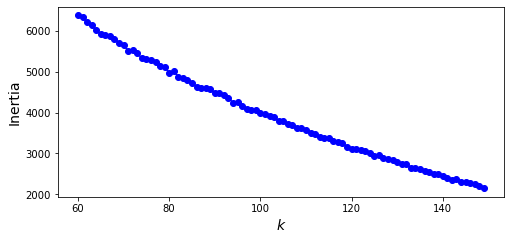

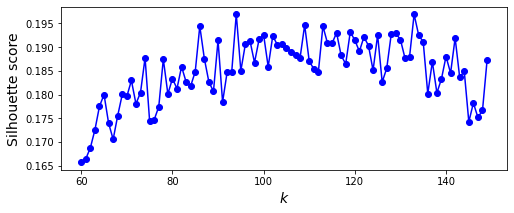

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# since we have 40 classes, taking 60 as a start of no of clusters is adequate.
cluster_range = range(60, 150)

kmeans_per_k = [KMeans(n_clusters=k, random_state=11).fit(X_train)
                for k in cluster_range]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X_train, model.labels_)
                     for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(cluster_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(cluster_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [15]:
n_clusters = 60 + silhouette_scores.index(max(silhouette_scores))
print(f"number of clusters with the highest silhouette score: {n_clusters}")

number of clusters with the highest silhouette score: 94


From Inertia plot, we couldn't find apparent elbow point. <br>
Even though silhouette score fluctuates as well, we can see that it peaks at around 100.

To get reduced X, let's instantiate Kmeans with n_cluster with best silhouette score.

In [16]:
kmeans = KMeans(n_clusters=n_clusters)
X_reduced = kmeans.fit_predict(X_train)

### 5. Use reduced dataset made by K-Means to train a classifier

For this time, let's use reduced X to train and evaluate a classifier. <br>
Since we are going to evaluate with validation set separately as we did above, it would be convenient to use pipeline.

In [17]:
from sklearn.pipeline import Pipeline

clf_kmeans_svc = Pipeline([
    ("kmeans", KMeans(n_clusters=n_clusters)),
    ("svc", SVC(kernel = 'linear'))
])
    
scores = cross_val_score(clf_kmeans_svc, X_train, y_train, cv=7)
print(f'SVC with reduced set by KMeans: {scores} - avg: {np.mean(scores):.2f}, std: {np.std(scores):.2f}')

SVC with reduced set by KMeans: [0.85  0.875 0.8   0.8   0.875 0.85  0.9  ] - avg: 0.85, std: 0.04


Considering that we reduced dimensionality from 4096 to 106, 0.85 of accuracy is not bad grade. <br>
Let's check with validation set as well as we did to original dataset.

In [18]:
clf_kmeans_svc.fit(X_train, y_train)
y_pred_validation = clf_kmeans_svc.predict(X_validation)

accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f'Accuracy score on validation set: {accuracy_validation}')

Accuracy score on validation set: 0.925


It showed better result in validation set compared to cross validation score. <br>
Finally, let's see how it goes with test set.

In [19]:
y_pred_test = clf_kmeans_svc.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy score on test set: {accuracy_validation}')

Accuracy score on test set: 0.925


Final check with test set shows the same result (92.5%) with that of before dimensionality reduction.

From this result, we can see that <br>
1. With K-Means, we can reduce dimensionality drastically. (from 4096 to 94)
2. Even with reduction of dimensionality, it doesn't lose information variance. 

### 6. Plus: Comparison with PCA

PCA is another representative way to reduce dimensionality. <br>
From this part, let's apply PCA instead of K-Means clustering, and compare the results.

As it is important to pick good number of clusters in K-Means, it is also very crucial to select best number of components in PCA. We commonly pick number of components where explained variance ratio is bigger than 90%. This time we chose the point where it preserves 95% of information.

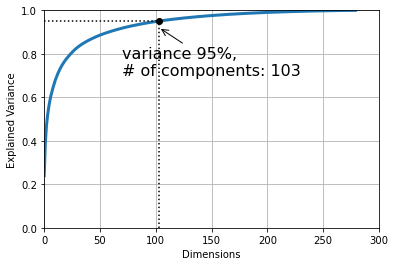

In [20]:
from sklearn.decomposition import PCA

pca=PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate(f"variance 95%, \n# of components: {d}", xy=(d, 0.92), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

Since we have found the number of dimensions (103) where 95% of information is preserved, <br>
let's instantiate PCA with this number and see the result.

In [21]:
clf_pca_svc = Pipeline([
    ("kmeans", PCA(n_components=d)),
    ("svc", SVC(kernel = 'linear'))
])
    
scores = cross_val_score(clf_pca_svc, X_train, y_train, cv=7)
print(f'SVC with reduced set by PCA: {scores} - avg: {np.mean(scores):.2f}, std: {np.std(scores):.2f}')

SVC with reduced set by PCA: [0.9   0.925 0.95  0.95  0.925 0.975 0.975] - avg: 0.94, std: 0.03


In [22]:
clf_pca_svc.fit(X_train, y_train)
y_pred_validation = clf_pca_svc.predict(X_validation)

accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f'Accuracy score on validation set: {accuracy_validation}')

y_pred_test = clf_pca_svc.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy score on test set: {accuracy_validation}')

Accuracy score on validation set: 0.975
Accuracy score on test set: 0.975


Similar to the case with K-Means, with PCA, we could reduce dimensionality to around 100.<br> 
Furthermore, we could get slightly better result than that of K-Means.

### 7. Plus 2: PCA -> K-Means

Finally, we decided to try applying two layers of dimensionality reduction, because we thought raw image dataset could be a little noisy for K-Means, even though it showed good results already.

Let's create reduced X with PCA, and find the number of clusters with the highest silhouette score.

Number of clusters with the highest silhouette score: 99


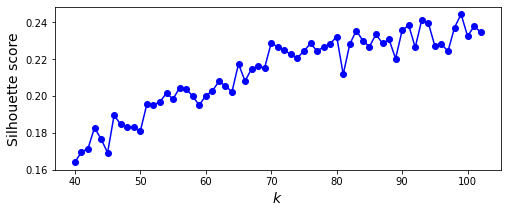

In [23]:
from sklearn.metrics import silhouette_score

pca = PCA(n_components=d)
X_pca_reduced = pca.fit_transform(X_train)
cluster_range = range(40, d)

kmeans_per_k = [KMeans(n_clusters=k, random_state=11).fit(X_pca_reduced)
                for k in cluster_range]
silhouette_scores = [silhouette_score(X_pca_reduced, model.labels_)
                     for model in kmeans_per_k]

n_clusters = 40 + silhouette_scores.index(max(silhouette_scores))
print(f'Number of clusters with the highest silhouette score: {n_clusters}')

plt.figure(figsize=(8, 3))
plt.plot(cluster_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

So, now that we found the number of clusters with highest silhouette_score, let's create pipeline and check. <br>
It is interesting that peak of silhouette score is located close to max of dimensionality. <br>
We think that it is because already valuable dimensions are taken by PCA. <br>
It clusters better as number of dimensions increases since these dimensions are already filtered ones.

In [24]:
clf_pca_kmeans_svc = Pipeline([
    ("pca", PCA(n_components=d)),
    ("kmeans", KMeans(n_clusters=n_clusters)),
    ("svc", SVC(kernel = 'linear'))
])

scores = cross_val_score(clf_pca_svc, X_train, y_train, cv=7)
print(f'SVC with reduced set by PCA and KMeans: {scores} - avg: {np.mean(scores):.2f}, std: {np.std(scores):.2f}')

SVC with reduced set by PCA and KMeans: [0.9   0.925 0.95  0.95  0.925 0.975 0.975] - avg: 0.94, std: 0.03


In [25]:
clf_pca_kmeans_svc.fit(X_train, y_train)
y_pred_validation = clf_pca_kmeans_svc.predict(X_validation)

accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f'Accuracy score on validation set: {accuracy_validation}')

y_pred_test = clf_pca_kmeans_svc.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy score on test set: {accuracy_validation}')

Accuracy score on validation set: 0.9
Accuracy score on test set: 0.9


Even with two steps of dimensionality reduction, we have got to achieve 90% of accuracy.<br>
Thinking that we have lost only 2.5% - 7.5% point from the case of original dataset, it is surprising.